# План проекта

### Название и описание проекта

# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

а услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Загрузка данных

**Загрузка необходимых библиотек и модулей:** Производим не с помощью конструкции try/expect, по причине выполнения работы во встроенном юпитере практикума.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score # выгружаю дополнительные с заделом на будущее
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoostClassifier
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

**Выгрузка данных датасетов:**

In [ ]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

Как описано в условии датасеты содержат следующую информацию:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Следовательно, на первом этапе надо бы изучить каждый из них, понять какие столбцы храняться и какую полезную информацию (в том числе и для дальнейшего обучения) мы можем из них получить

### Исследование каждого датафрейма

#### Датафрейм contract

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


В наличии у нас 8 столбцов, так как информации по столбцам я не нашел, как в прошлых проектах, опишем, как понимаем, для чего данные столбцы существуют:
- `customerID` — уникальный индификатор клиента;
- `BeginDate` — дата заключения договора;
- `EndDate` — дата расторжения договора;
- `Type` — тип оплаты (категориальный столбец, исходя из данных столбца, можно платить от месяца к месяцу - месячная подписка, или взять сразу на год).
- `PaperlessBilling` — наличие безбумажного выставления счета (думаю речь об электронных чеках или что-то типо того);
- `PaymentMethod` — способ оплаты; (категориальный)
- `MonthlyCharges` — ежемесячная плата;
- `TotalCharges` — выплачено за все время

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков не обнаружено - рыдаем от счастья на предобработки! Правда это только 1 из 4 датасетов, думаю в дальнейшем без пропусков не обойдется.
Есть проблема соответствию типу данных, так, например:
- `BeginDate` — символьный тип данных, когда можем привест к datetime;
- `EndDate` — в идеале тоже datetime, но что делать, если день расторжения не наступил? Да и так ли важна для нашей задачи точная дата расторжения договора, больше важен факт расторжения, **поменял бы на булевый - выношу как вопрос;** UPD: вопрос решен после просмотра записи встречи.
- `TotalCharges` — необходимо привести к типу данных с плавающей запятой, он же float

Еще стоит сказать о нарушении стилистики наименования столбцов, нужен snake_case. Правда столько всего делать и это только с одной таблицей, что же будет дальше, видимо пора оформлять заказ на ящик энергетиков!

In [ ]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Из-за типов данных получаем малоинформативный дескрайб, но зато можно сказать, что забесплатно никто не получает услуги компании:)

array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

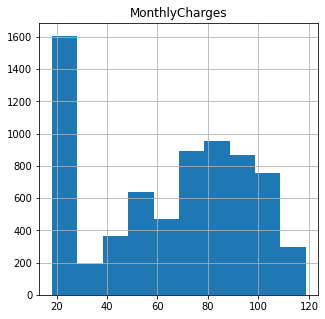

In [ ]:
contract.hist(figsize=(5, 5))

Опять же, из-за битых типов данных, гистограмки с кайфом не построишь. По данной можно сказать, что бОльшинство сидят на достаточно бюджетном тарифе. Проверим на дубликаты:

In [ ]:
contract.duplicated().sum()

0

Проверим категориальные столбцы, чтобы понимать с какими категориями работаем в дальнейшем, может есть какая-то неинформативная:

In [ ]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Контракт может оформляться ежемесячно, на год и на два, все логично.

In [ ]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Тут тоже без сюрпризов

In [ ]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Оплата производится по электронному чеку, почтовому чеку, банковскому переводу (автоматически) и переводу с кредитной карты (автоматически). Тоже логично и без странностей

#### Датафрейм personal

Повторим шаги, которые выполняли выше, вообще можно было свалить все в цикл, но мне лично как-то удобнее по пунктам передвигаться, несмотря на объемность такого выбора

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В наличии у нас 5 столбцов, так как информации по столбцам я не нашел, как в прошлых проектах, опишем, как понимаем, для чего данные столбцы существуют:
- `customerID` — все тот же уникальный индификатор клиента;
- `gender` — пол человека;
- `SeniorCitizen` — согласно гугл переводчику - Пожилой гражданин, думаю столбец, который показывает пенсионер ли клиент;
- `Partner` — наличие партнера(супруга);
- `Dependents` — иждивенец, вероятно речь идет о безработном.

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков все также не найдено, да и количество столбцов соответствуют количеству столбцов в датасете выше, все вроде четко

Есть проблема соответствию типу данных, так, например:
- `SeniorCitizen` — привести к булевому или строчному (в дальнейшем же будет кодировка и даже строчный тип данных подойдет) типу;

Еще стоит сказать о нарушении стилистики наименования столбцов, нужен snake_case.

In [ ]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Из-за типов данных получаем малоинформативный дескрайб, но зато можно сказать, что большинство выборки молодежь:)

array([[<AxesSubplot:title={'center':'SeniorCitizen'}>]], dtype=object)

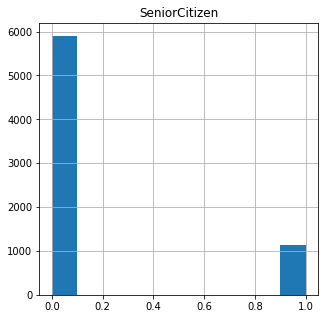

In [ ]:
personal.hist(figsize=(5, 5))

Опять же, из-за битых типов данных, гистограмки с кайфом не построишь. По данной можно сказать, что бОльшинство все-таки молодежь, хотя это было понятно еще на стадии дескрайба! Проверим на дубликаты:

In [ ]:
personal.duplicated().sum()

0

Тут тоже проверим наши категории, вдруг есть какая-то потеряшка

In [ ]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [ ]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [ ]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [ ]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [ ]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Все в рамках разумного!

#### Датафрейм internet

Повторим шаги, которые выполняли выше

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Тут датасет на подключенные услуги интернета, интернет сервис - категориальный, остальный бинарные.

В наличии у нас 8 столбцов, и наконец-то какая то информация о них имеется в условии, а именно:


Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно. - **стобец с этой информацией пока не найден, но есть еще один датасет, где она может храниться, не зря она носит название phone**
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). - **Это и есть столбец InternetService**

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

In [ ]:
internet.info()

Пропусков нет, но строк меньше, чем в предыдущих двух датасетах, чем это черевато - непонятно, но судя по сообщениям в тг, там поступает предложение объединить все данные в одну таблицу, и предложение неплохое, но что делать с несоответствиями строк - непонятно, **вынесем в вопросы** UPD: вопрос решен после просмотра встречи.

Еще стоит сказать о нарушении стилистики наименования столбцов, нужен snake_case.

In [ ]:
internet.describe()

Тут дескрайб получен, но для таблиц выше его не было, не понимаю почемууу:C, **вынесем в вопросы**
А так все хорошо, айдишники действительно уникальны, а все признаки имеют ровно две категории, как и должны, даже value_counts() не потребуется

Проверим на дубликаты:

In [ ]:
internet.duplicated().sum()

#### Датафрейм phone

Повторим шаги, которые выполняли выше

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В наличии у нас 2 столбеца - наличие телефонной услуги и уникальный индификатор клиента

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет, но количество строк отличается от первых двух

Еще стоит сказать о нарушении стилистики наименования столбцов, нужен snake_case.

In [ ]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8182-PNAGI,No
freq,1,3390


Уникальные айдишники и 2 категории для столбца который показывает подключенную услугу для телефона - все в норме

In [ ]:
personal.duplicated().sum()

0

### Выводы по ознакомлению с данными

1. Наименования столбцов в датасетах не соответствую snake_case.
2. В датасетах internet и phone, меньше данных, чем в двух других. Терять данные нельзя, поэтому логичнее объединить все 4 таблицы в одну, а потом заполнить по возможности полученные пропуски чем-то
3. В датасетах contract и personal имеются столбцы, необходимые в приведении к другому типу данных

### План работы

1. Осуществить предобработку и подготовку к обучению данных:
- Смержить таблицы без потери данных
- Привести столбцы к соотвествующим типам данных
- Привести наименование столбцов к snake_case
- Подумать, чем можно заполнить пропуски и заполнить их
- Попробовать найти аномалии и выбросы, в случае их присутсвия - снести
- Добавить столбцы, которые помогут в обучении (срок жизни клиента в компании, явно получить таргетный признак бинарной классификации)
- Снести столбцы которые могут коррелировать с другими
2. Выбрать модель:
- Определить 3 наиболее подходящие модели для решения задачи
- Разделить выборку на обучающую и тестовую
- Провести кодирование (ое - для древовидных моделей, охе - для линейных, для бустингов - гиперпараметр)
- Масштабирование (для линейных)
- С помощью GridSearchCV опеределить лучшие параметры (не забыть установить про параметр cv)
- Проверить лучшую модель на тестовой выборке
- Анализ лучшей модели (важность признаков + матрица ошибок)
- Описать выводы

Избегать:
- Борьбы с дисбалансом (наша метрика устойчива)
- get_dummies()

Мною выбраны и будут рассматриваться три модели: LogisticRegression, CatBoostClassifier, LGBMClassifier

### Вопросы

Нет вопросов. Все отпали после вводной лекции.

## Часть два: Код решения

# Проблемные вопросы после первого этапа
1. Наименования столбцов в датасетах не соответствую snake_case.
2. В датасетах internet и phone, меньше данных, чем в двух других. Терять данные нельзя, поэтому логичнее объединить все 4 таблицы в одну, а потом заполнить по возможности полученные пропуски чем-то
3. В датасетах contract и personal имеются столбцы, необходимые в приведении к другому типу данных

## Предобработка и подготовка данных к обучению

### Объедение датасета

In [ ]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Объединим столбцы по ключу айдишника пользователя, укажем параметр присоединения слева, без параметра how, строчки с пропусками канут в лету.

In [ ]:
data = contract.merge(internet, on='customerID', how='left')
data = data.merge(personal, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


Пропусков много, но они все касаются категориальных признаков, наличия дополнительных услуг интернета и телефонии. Удалять строки с ними - потеря данных, она не запрещена. А предопложить, что раз нет данных об услугах - то скорее всего данные пользователи и не обращались за ними, думаю можно заполнить отсуствием данных услуг, так и поступлю в дальнейшем.

### Привести стобцы к соотвествующим типам данных

- `BeginDate` — символьный тип данных, когда можем привест к datetime;
- `EndDate` — в идеале тоже datetime, но что делать, если день расторжения не наступил
- `TotalCharges` — необходимо привести к типу данных с плавающей запятой, он же float

In [ ]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
#data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')
#data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

В ходе попытки привести в нужный тип данных, выяснилось, что во-первых, в столбце EndDate имеется слово, поэтому так сразу не удастся, поэтому прежде нужно заменить, и самое логичное, заменить днем выгрузки данных - 1 февраля 2020 года.
Также в столбце TotalCharges имеется пробел, нужно от него избавится, вероятно подобного рода пропуск логично заменить 0.
Посмотрим на срез данных с пробелом

In [ ]:
data.loc[data['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Данные пользователи только подписали договор, в день выгрузки данных - 1 февраля 2020, значит пока что не оплатили данную услугу. Поэтому суммарные выплаты и отсуствуют, заменим их на 0.

In [ ]:
data.loc[data['TotalCharges'] == ' ', 'TotalCharges']  = 0

Что касаемо столбца с окончанием договора, я уже описал выше, что логично записать днем выгрузки. У нас выйдет огромная категория клиентов которые до сих пор с нами. Вообще можно добавить признак дополнительный, который бы показывал, что клиент все еще пользуется услугой, не знаю насколько это идея поможет, но пока что заменим днем, все равно необходимо заменить тип данных, а этого без даты не сделаешь

In [ ]:
#data.loc[data['EndDate'] == '2020-02-01'].count()

In [ ]:
data.loc[data['EndDate'] == 'No', 'EndDate']  = '2020-02-01'

In [ ]:
#data.loc[data['EndDate'] == '2020-02-01'].count()

Повторим преобразование стобцов:

In [ ]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

### Наименование столбцов к snake_case

In [ ]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines'],
      dtype='object')

In [ ]:
data.rename(columns = {'customerID':'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date', 'Type':'type',
                    'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method',
                       'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges',
                    'InternetService':'internet_service', 'OnlineSecurity':'online_security',
                       'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection',
                      'TechSupport':'tech_support', 'StreamingTV':'streaming_tv',
                       'StreamingMovies':'streaming_movies', 'SeniorCitizen':'senior_citizen', 'Partner':'partner',
                       'Dependents':'dependents', 'MultipleLines':'multiple_lines'}, inplace = True)

In [ ]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')

### Заполнение пропусков

In [ ]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

In [ ]:
data[['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']]

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,DSL,No,Yes,No,No,No,No,NaN
1,DSL,Yes,No,Yes,No,No,No,No
2,DSL,Yes,Yes,No,No,No,No,No
3,DSL,Yes,No,Yes,Yes,No,No,NaN
4,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
7038,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,DSL,Yes,No,No,No,No,No,NaN
7041,Fiber optic,No,No,No,No,No,No,Yes


Как и говорилось выше, пропуски в категориальных признаках указывающих на наличие определенных услуг. Все столбцы кроме internet_service предлагаю заполнить значением No. Вот оставшийся столбец уже не совсем бинарный, но все же можно и тут заполнить значениями No, создать третью категорию в этом признаке - потому что, предполагаю, что есть люди не пользующиеся услугами интернета.

In [ ]:
for i in ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    data[i] = data[i].fillna('No')

In [ ]:
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

### Исследовательский анализ, поиск аномалий

Для начала создадим гистограммы для датасета, через .hist(), он не выведет категориальных переменных, но даст некоторую информацию для размышления. В красивой визуализации я не постиг дзен, поэтому будем пользоваться дефолтной pandas

array([[<AxesSubplot:title={'center':'begin_date'}>,
        <AxesSubplot:title={'center':'end_date'}>],
       [<AxesSubplot:title={'center':'monthly_charges'}>,
        <AxesSubplot:title={'center':'total_charges'}>],
       [<AxesSubplot:title={'center':'senior_citizen'}>, <AxesSubplot:>]],
      dtype=object)

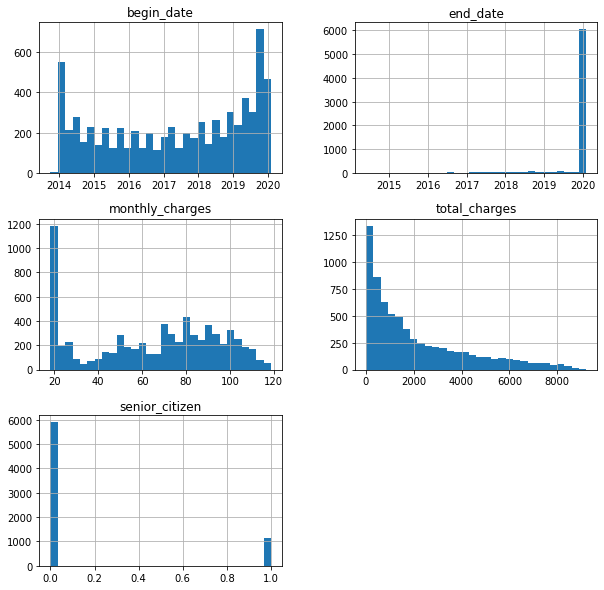

In [ ]:
data.hist(figsize=(10, 10), bins = 30)

- На графике begin_data, видим некоторые резкие приросты, может быть они связаны с рекламными компаниями. В целом видим положительный тренд к концу изучаемого периода.
- На графике end_date - явный выброс? Вовсе нет, просто мы всех клиентов, которые сохранились, списали в конце изучаемого периода, видно, что большинство все-таки остается с данным оператором.
- На графике ежемесячных выплат видим, что большинство сидит на более недорогих тарифах
- По общим выплатам, можно выдвинуть гипотезу, что большинство клиентов все-таки новички, мало кто выплатил за весь период более 2000 у.е.
- По последнему графику можно сказать, что число пенсионеров меньше в ~5 раз

<AxesSubplot:xlabel='Type', ylabel='Count'>

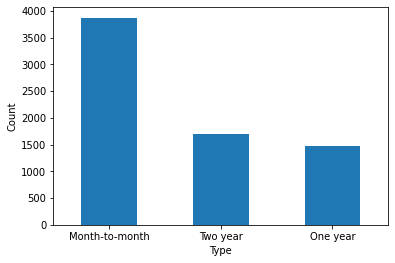

In [ ]:
data['type'].value_counts().plot(kind='bar', xlabel= 'Type', ylabel ='Count', rot =0)

Самая популярная оплата - по месячная, звучит здраво

<AxesSubplot:xlabel='paperless_billing', ylabel='Count'>

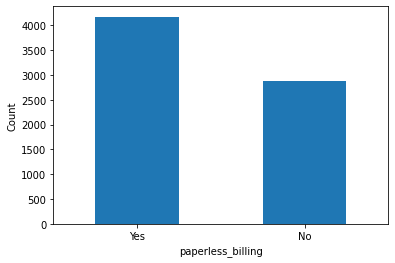

In [ ]:
data['paperless_billing'].value_counts().plot(kind='bar', xlabel= 'paperless_billing', ylabel ='Count', rot =0)

Большинство предпочитают не возиться с бумажками

<AxesSubplot:xlabel='payment_method', ylabel='Count'>

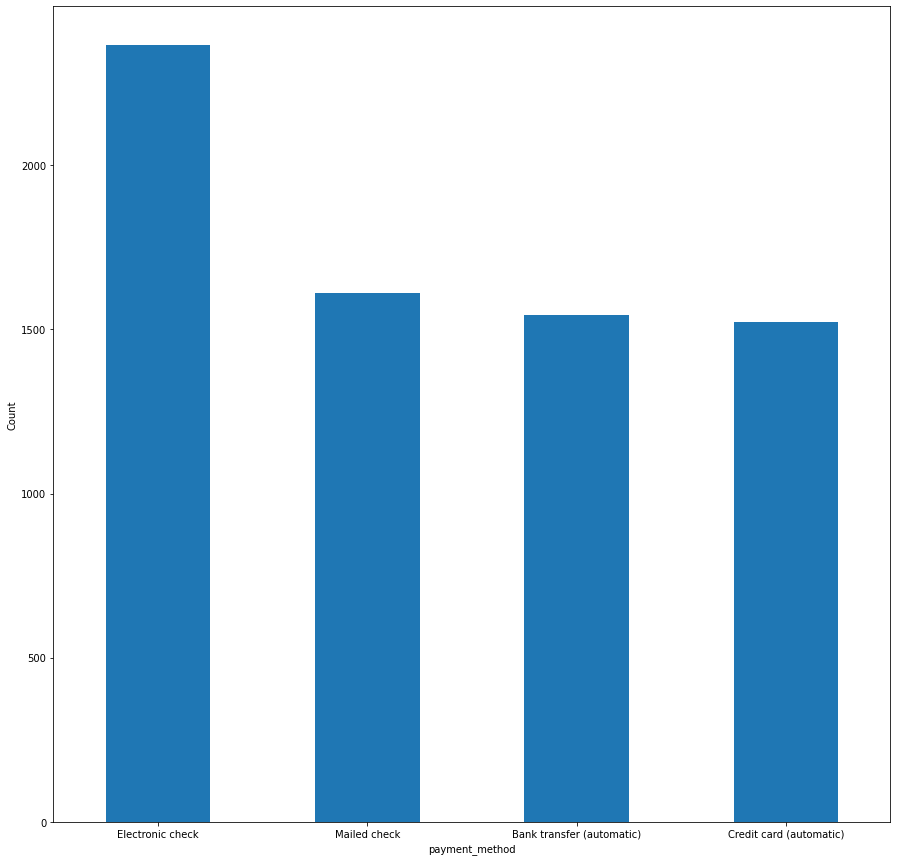

In [ ]:
data['payment_method'].value_counts().plot(kind='bar', xlabel= 'payment_method', ylabel ='Count', rot =0, figsize = (15,15))

Достаточно большое количество людей предпочитают автоматическую оплату (хотя лично я такое стараюсь избегать), электронный чек - самый популярный, вроде все в порядке, без сюрпризов.

<AxesSubplot:xlabel='online_security', ylabel='Count'>

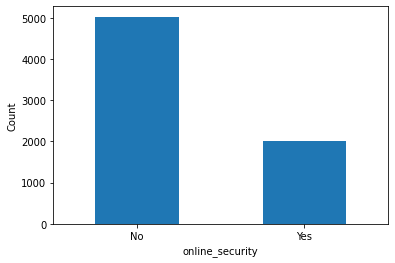

In [ ]:
data['online_security'].value_counts().plot(kind='bar', xlabel= 'online_security', ylabel ='Count', rot =0)

Защита данных нам не нужна, на терять в ваших интернетах нечего

<AxesSubplot:xlabel='online_backup', ylabel='Count'>

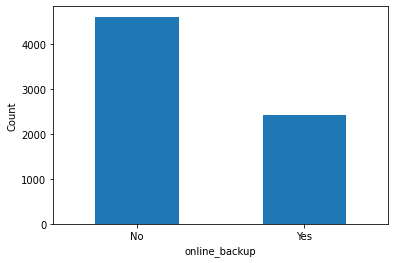

In [ ]:
data['online_backup'].value_counts().plot(kind='bar', xlabel= 'online_backup', ylabel ='Count', rot =0)

<AxesSubplot:xlabel='device_protection', ylabel='Count'>

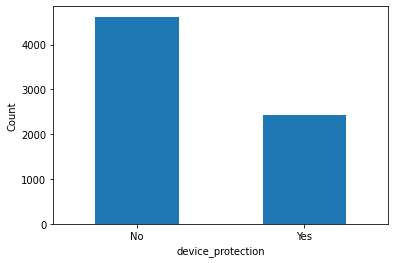

In [ ]:
data['device_protection'].value_counts().plot(kind='bar', xlabel= 'device_protection', ylabel ='Count', rot =0)

<AxesSubplot:xlabel='tech_support', ylabel='Count'>

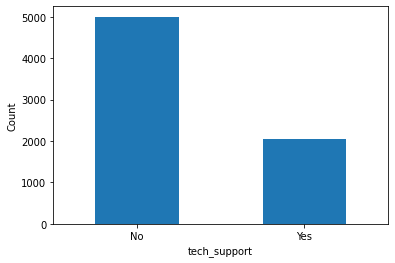

In [ ]:
data['tech_support'].value_counts().plot(kind='bar', xlabel= 'tech_support', ylabel ='Count', rot =0)

<AxesSubplot:xlabel='streaming_tv', ylabel='Count'>

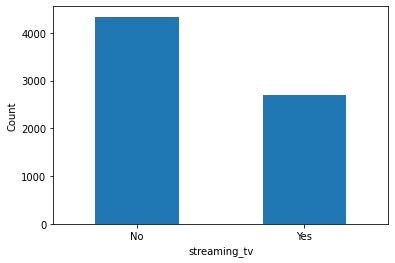

In [ ]:
data['streaming_tv'].value_counts().plot(kind='bar', xlabel= 'streaming_tv', ylabel ='Count', rot =0)

<AxesSubplot:xlabel='streaming_movies', ylabel='Count'>

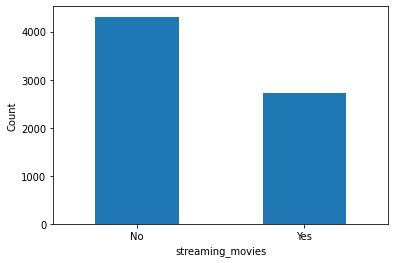

In [ ]:
data['streaming_movies'].value_counts().plot(kind='bar', xlabel= 'streaming_movies', ylabel ='Count', rot =0)

В целом по услугам интернета ожидаемо преобладает нет, я лично тоже не пользуюсь дополнительными опциями провайдера, мне и так хорошо живется

<AxesSubplot:xlabel='gender', ylabel='Count'>

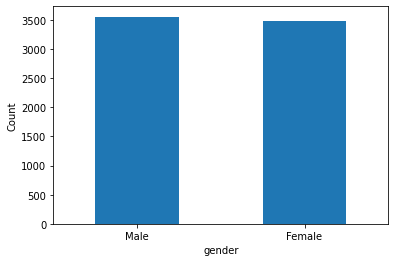

In [ ]:
data['gender'].value_counts().plot(kind='bar', xlabel= 'gender', ylabel ='Count', rot =0)

Почти идеальное равенство!

<AxesSubplot:xlabel='partner', ylabel='Count'>

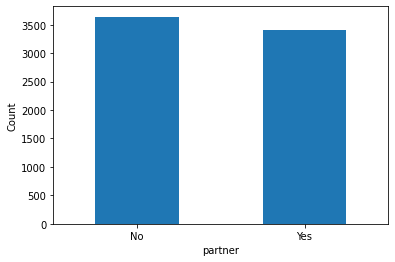

In [ ]:
data['partner'].value_counts().plot(kind='bar', xlabel= 'partner', ylabel ='Count', rot =0)

Преобладают свободные от обязательств люди

<AxesSubplot:xlabel='dependents', ylabel='Count'>

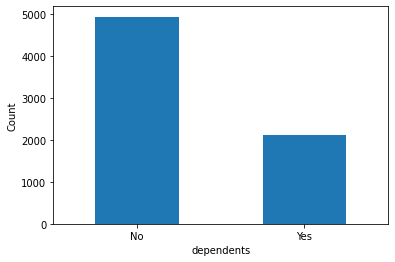

In [ ]:
data['dependents'].value_counts().plot(kind='bar', xlabel= 'dependents', ylabel ='Count', rot =0)

Людей в браке - меньше большинства, а с детьми еще меньше.

<AxesSubplot:xlabel='multiple_lines', ylabel='Count'>

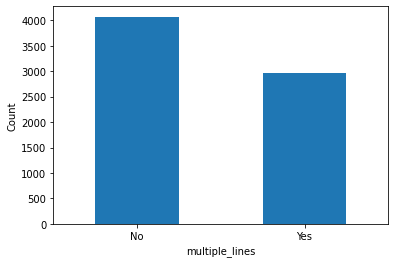

In [ ]:
data['multiple_lines'].value_counts().plot(kind='bar', xlabel= 'multiple_lines', ylabel ='Count', rot =0)

Услуги телефонной связи тоже не особо востребованы

Вроде никаких существенных аномалий выявлено не было!

### Добавить столбцы, которые помогут в обучении

В первую очередь необходимо добавить столбец, который показывает срок присутствия клиента в компании, в днях.

In [ ]:
data['days_with_company'] = (data['end_date'] - data['begin_date']).dt.days

In [ ]:
data['days_with_company']

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: days_with_company, Length: 7043, dtype: int64

Задача звучала изначально без понимания, как это сделать, но первая же ссылка на стаковерфлоу помогла мне справится, ехуу.
Теперь добавим таргетный признак в явном виде! Для начала нужно сделать проверку (она закоммичена в блоке 1.2) на то, были ли у нас записи на дату, которую мы присвоили день выгрузки данных. Ответ - нет, значит мы можем смело создать дополнительный столбец по 1 февраля. Задача звучит как "Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.", следовательно 1 присваивается покинувшему нас клиенту, 0 все остальные.

In [ ]:
data['left_the_company'] = 0
data.loc[data['end_date'] != '2020-02-01', 'left_the_company'] = 1

In [ ]:
data['left_the_company'].value_counts()

0    5942
1    1101
Name: left_the_company, dtype: int64

Баланса классов нет, но метрика устойчива - значит игнорим.

### Снести столбцы которые могут коррелировать с другими

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,monthly_charges,total_charges,senior_citizen,days_with_company,left_the_company
monthly_charges,1.000000,0.630440,0.220173,0.220054,0.154286
total_charges,0.630440,1.000000,0.093985,0.821746,0.052175
senior_citizen,0.220173,0.093985,1.000000,0.005283,0.056724
days_with_company,0.220054,0.821746,0.005283,1.000000,0.016578
left_the_company,0.154286,0.052175,0.056724,0.016578,1.000000


Как видим из данных очень коррелируют суммарные выплаты с днем компании, что логично, чем дольше человек пользуется услугами - тем больше он платит, снесем этот столбец, чтобы избежать обучения.
Правда мапа не построилась для категориальных фич, не знаю, насколько это трагично, но думаю что вряд ли там одна из другой происходит, как в данном случае.

In [ ]:
data.drop('total_charges', axis=1 , inplace=True)

Снесем также айдишники, они не несут полезной для обучения информации

In [ ]:
data.drop('customer_id', axis=1 , inplace=True)

## Деление выборки, выбор модели, проверка на тестовой лучшей из них.

### Деление выборки и подготовка к обучению

Снесем из данных столбцы, которые не дадут пользы:

In [ ]:
data.drop(['end_date', 'begin_date'], axis=1 , inplace=True)

Разбиваем на фичи и таргет:

In [ ]:
target = data['left_the_company']
features = data.drop('left_the_company', axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            train_size=.75, #test_size = 0.25
                                                                            random_state=80523)

In [ ]:
#!pip install sklearn --user

**Я очень много времени потерял на попытке сделать через ОХЕ здорового человека, но я больше так не могу, обязательно добью и попробую, как точно сдам проект, а сейчас похоже придется страдать через гет_даммиес (как я понял с созвона - это очень нежелательно, но возможно, прямого запрета на это не прозвучало), да простят меня боги аналитики данных
Ниже оставлю код, который когда-то давал ревьювер на каком-то из проектов и который я ковырял, но не доковырял** UPD: осознал ошибку, после наката склерна, я не перезапустил весь проект, может из-за этого ловил ошибку, в прочем уже сделал как сделал, потом доковыряю:CCCC

In [ ]:
#encoder = OneHotEncoder(handle_unknown='error', drop='first') #удаляем первый столбец чтобы не попасть в дамми-ловушку
#var_categorical = ['type', 'paperless_billing','payment_method', 'internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender',  'senior_citizen', 'partner', 'dependents', 'multiple_lines']

#features_train_ohe = pd.DataFrame(
#    encoder.fit_transform(features_train[var_categorical]).toarray(),
#    columns=encoder.get_feature_names_out()
#)

#features_test_ohe = pd.DataFrame(
#    encoder.transform(features_test[var_categorical]).toarray(),
#    columns=encoder.get_feature_names_out()
#)

In [ ]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)

In [ ]:
features_test_ohe = pd.get_dummies(features_train, drop_first=True)

In [ ]:
features_test.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'days_with_company'],
      dtype='object')

Осуществим проверку (воспользуемся данными файла из коллабы, который нашел в тг)

In [ ]:
for i in ['type', 'paperless_billing', 'payment_method',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']:
    column_train = set(features_train[i].unique())
    column_test = set(features_test[i].unique())
    num_column_train = len(column_train)
    num_column_test = len(column_test)
    print(i)
    print(f'''
    Количество уникальных значений признка
    в обеих выборках одинаковое: {num_column_train == num_column_test}
    ''')
    print(f'''
    Уникальные значения признка
    в обеих выборках одинаковые: {column_train == column_test}
    ''')
    print(f'''
    Только в тренировочной выборке есть значения: {column_train - column_test}
    ''')
    print(f'''
    Только в тестовой выборке есть значения: {column_test - column_train}
    ''')

type

    Количество уникальных значений признка  
    в обеих выборках одинаковое: True
    

    Уникальные значения признка 
    в обеих выборках одинаковые: True
    

    Только в тренировочной выборке есть значения: set()
    

    Только в тестовой выборке есть значения: set()
    
paperless_billing

    Количество уникальных значений признка  
    в обеих выборках одинаковое: True
    

    Уникальные значения признка 
    в обеих выборках одинаковые: True
    

    Только в тренировочной выборке есть значения: set()
    

    Только в тестовой выборке есть значения: set()
    
payment_method

    Количество уникальных значений признка  
    в обеих выборках одинаковое: True
    

    Уникальные значения признка 
    в обеих выборках одинаковые: True
    

    Только в тренировочной выборке есть значения: set()
    

    Только в тестовой выборке есть значения: set()
    
internet_service

    Количество уникальных значений признка  
    в обеих выборках одинаковое: True
    



Фичи абсолютно идентичны, везде пустые множества отличий, значит модели смогут на этом работать

In [ ]:
features_train.head()

,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,days_with_company
1214,Month-to-month,Yes,Bank transfer (automatic),86.00,Fiber optic,No,No,No,No,No,Yes,Male,0,No,No,Yes,671
827,Month-to-month,No,Mailed check,25.55,No,No,No,No,No,No,No,Female,0,Yes,Yes,Yes,427
6266,Month-to-month,Yes,Credit card (automatic),83.85,Fiber optic,No,Yes,Yes,No,No,No,Male,1,No,No,Yes,1036
1010,Month-to-month,Yes,Mailed check,50.15,DSL,Yes,No,No,No,No,No,Male,0,No,No,No,92
4397,Two year,Yes,Bank transfer (automatic),103.95,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,No,Yes,2191


Сделаем масштабирование (в конце, так как о нем я немного подзабыл), до него метрика рок_аус давала значения 0.75 в гридсерче линейной регрессии.
После масштабирования показатели улучшились до ~0.76. На лгбм ~0.87 до и ~0.87 после (но скорость обучения заметно ухудшилась). Поэтому немного не понимаю, так ли необходимо ли нам масштабирование в данной задаче. Судя по финальным весам фич - самая весомя это дни в компании, а масштабированием мы уменьшаем ее влияние.

In [ ]:
scaler = StandardScaler()
numeric = ['monthly_charges', 'days_with_company']
scaler.fit(features_train[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

### Поиск лучшей модели

Гридсерч будет использоваться с параметром кросс валидации = 3/4, где это позволяет время, знаю, что золотой стандарт 5 (4 обучающих, одна под валид), но боюсь заснуть с кружкой кофе в ожидании компиляции ячейки, поскольку обучение в кроссвалидации происходит множество раз за гридсерч и можно сойти с ума. Знаю про оптуну, но в виду очень малого количества времени, решил воспользоваться технологиями, которые успел познать за время обучения. Также гиперпараметры почти не подбирал в виду опасений работы тренажера, который может откинуться, значение метрики получили и на них нормальные, но если нужно будет накинуть больше - накинем

In [ ]:
%%time
lr = LogisticRegression(random_state=80523,class_weight='balanced')
hyper = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'C': [0.1,1,10]
        }
gscv_lr = GridSearchCV(lr, hyper, cv=4, scoring='roc_auc')
gscv_lr.fit(features_train_ohe, target_train)
print('Лучшие параметры: ', gscv_lr.best_params_)
print('roc_auc', gscv_lr.best_score_)

Лучшие параметры:  {'C': 10, 'solver': 'lbfgs'}
roc_auc 0.7560676013346155
CPU times: user 8.62 s, sys: 20.2 s, total: 28.8 s
Wall time: 29.1 s


In [ ]:
%%time
cbc = CatBoostClassifier(random_state=80523, verbose = False,class_weights=None, cat_features = ['type', 'paperless_billing','payment_method', 'internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender',  'senior_citizen', 'partner', 'dependents', 'multiple_lines'])
hyper = {'learning_rate': [0.1, 0.2, 0.5],
               'max_depth': [2,5,8]
        }
gscv_cbc = GridSearchCV(cbc, hyper, cv=3, scoring='roc_auc')
gscv_cbc.fit(features_train, target_train)
print('Лучшие параметры: ', gscv_cbc.best_params_)
print('roc_auc', gscv_cbc.best_score_)

Лучшие параметры:  {'learning_rate': 0.5, 'max_depth': 2}
roc_auc 0.9267969394385132
CPU times: user 3min 41s, sys: 6.05 s, total: 3min 47s
Wall time: 4min 41s


Несмотря на то, что на созвоне говорилось, что лгбм лучше работает без какого-либо кодирования, у меня обычные фичи он принял с ошибкой, что данные не могут быть обработаны с данными типами данных, а при кодировании прогнался, отсюда вопрос, почему так:C
**upd: выпили подбор гиперпараметров, работает на одном на море в виду либо большой нагруженности, или что-то задел (в чем сомневаюсь, вроде проглядел ошибок быть не должно, раньше прогонялось в разы дольше). Боюсь опоздать сдать проект, поэтому отправлю так, нужно хотя бы первые ошибки получить, чтобы успеть к жесткому дедлайну.** Значение метрики полученное в коллабе = 0.8679220010050477

In [ ]:
%%time
model_lgbm = lgb.LGBMClassifier(random_state = 80523)
hyper = { 'num_leaves': [20], # , 40, 100],
               'learning_rate': [0.1] #, 0.2, 0.3],
             }
grid_lgbm = GridSearchCV(model_lgbm, hyper, scoring='roc_auc', cv = 3)
grid_lgbm.fit(features_train_ohe, target_train)
print('Лучшие параметры: ', grid_lgbm.best_params_)
print('roc_auc', grid_lgbm.best_score_)

Лучшие параметры:  {'learning_rate': 0.1, 'num_leaves': 20}
roc_auc 0.8523845269687004
CPU times: user 17min 6s, sys: 12.6 s, total: 17min 19s
Wall time: 17min 51s


### Тестирование лучшей модели

Лучшей моделью оказалась CatBoostClassifier со следующими гиперпараметрами:
- random_state=80523
- learning_rate=0.5
- max_depth = 2
- verbose = False
- class_weights=None (хотя лучше наверное было сбалансировать, но метрика устойчива, поэтому и так сойдет)
- cat_features = ['type', 'paperless_billing','payment_method', 'internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender',  'senior_citizen', 'partner', 'dependents', 'multiple_lines'])

Для наглядного тестирования воспользуемся рок-кривой, код из которой я тащу из своего когда-то выполненного проекта на практикуме.

AUC-ROC CatBoostClassifier 0.9312197267819659


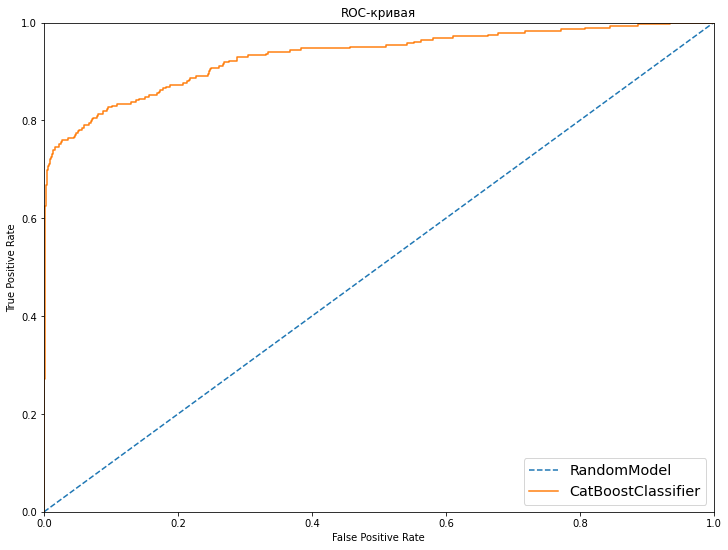

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

model =  CatBoostClassifier(random_state=80523, learning_rate=0.5,
                                                   max_depth = 2,verbose = False,class_weights=None, cat_features = ['type', 'paperless_billing','payment_method', 'internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender',  'senior_citizen', 'partner', 'dependents', 'multiple_lines'])
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC CatBoostClassifier',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

На графике видно, что модель в целом работает хорошо и приблизительно до 0.6 TPR абсолютно точно предсказывает таргет (FPR в окрестности нуля). Далее идет плавное снижение ранжирующей способности, но значение roc_auc 0.93 говорит о высокой предсказательной способности модели.

Построим матрицу ошибок:

In [ ]:
df_confusion = pd.DataFrame({'target':target_test.to_list(),
              'predict':predicted_valid})

In [ ]:
len(df_confusion)

1761

In [ ]:
tp = len(df_confusion[(df_confusion['target']==1)&(df_confusion['predict']==1)]) # Истинно позитивное предсказание
fp = len(df_confusion[(df_confusion['target']==0)&(df_confusion['predict']==1)]) # Ошибочно позитивное предсказание
tn = len(df_confusion[(df_confusion['target']==0)&(df_confusion['predict']==0)]) # Истинно отрицательное предсказание
fn = len(df_confusion[(df_confusion['target']==1)&(df_confusion['predict']==0)]) # Ошибочно отрицательное предсказание
full = len(df_confusion)

In [ ]:
tuples_pred = [('Прогноз',1),('Прогноз',0)]
tuples_target = [('Реальность',1),('Реальность',0)]
index = pd.MultiIndex.from_tuples(tuples_pred, names=["", ""],)
columns = pd.MultiIndex.from_tuples(tuples_target, names=["", ""],)
conf_matrix = pd.DataFrame(data = [[tp/full,fp/full],[fn/full,tn/full]],index=index,columns=columns)

In [ ]:
conf_matrix.style.background_gradient(cmap='coolwarm')

По данной матрице мы можем сказать, что виден дисбаланс классов, но даже так мы научили предсказывать модель приблизительно 11 случаев из 12, что в целом неплохой результат. В плане прогноза 0 мы вообще огромные молодцы, отличие ложных предсказаний от правильных приблизительно 20 раз, тут модель лучше обучилась.

Матрица важности признаков построена из данных полученных из гридсерча:

In [ ]:
most_value_features = pd.DataFrame(gscv_cbc.best_estimator_.feature_importances_, columns=['most_value_features'], index = features_test.columns)
most_value_features = most_value_features.sort_values(by='most_value_features')
print(most_value_features)

                   most_value_features
streaming_tv                  0.209200
gender                        0.332186
tech_support                  0.338158
senior_citizen                0.403238
online_security               0.461633
paperless_billing             0.470812
dependents                    0.616437
online_backup                 0.946334
streaming_movies              1.006241
internet_service              1.056299
device_protection             1.430983
multiple_lines                1.692707
partner                       1.993733
payment_method                2.466563
type                          5.787103
monthly_charges              13.061818
days_with_company            67.726557


Самый весомый признак - дни с компанией, добавленный нами признак. Пол же почти ни на что не влияет, феменистки празднуют победу!

## Вывод по второй части

1. В ходе работы мы успешно устранили недостатки выявленные в первой части, а именно:
    - соединили датасеты
    - заполнили пропуски
    - привели наименования столбцов к snake_case
    - добавили новые признаки
    - привели к адекватным типам данных те признаки, в которых были замечены несоответствия
    - удалили неинформативные и коррелирующие с другими признаками столбцы
    - провели исследовательский анализ, в поисках аномалий, но каких-то фатальных не обнаружили
2. Также в ходе работы было произведено разбитие выборок, произведено кодирование и масштабирование, выбраны 3 модели и с помощью гридсерча определена лучшая:
    - кодирование было произведено с помощью get_dummies() - не самым лучшим способом, но проверка на соотвествие фич была произведена, значит модели в дальнейшем обучаться нормально
    - лучшей моделью оказался CatBoostClassifier с гиперпараметрами {'learning_rate': 0.5, 'max_depth': 2}
    - для нее было проведено тестирование с помощью построения roc-кривой, получена auc-roc метрика = ~0.93, что соответствует поставленной задаче
    - построена матрица ошибок, ее данные позволяют удостоверится, что модель работает в целом достаточно на хорошем уровне
    - также была получена матрица важности признаков, в целом 80% успех предсказаний добивается всего лишь 2 фичами, это дни в компании и месячный платеж
3. Проблемы:
    - не победил библиотечное кодирование ohe, хотя потерял много времени
    - лгбм отказался прогонять данные без кодирования, хотя вроде должен был их принять
    - масштабирование так ли нужно, значения линейки подтянулись на сотую, а лгбм стал отрабатывать дольше (но это вероятно из-за тренажера)

## Отчет по проекту

В отчёте ответьте на вопросы:
- Какие пункты плана были выполнены, а какие — нет. Почему?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи вы выделили?
- Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?
- Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

### Какие пункты плана были выполнены, а какие — нет. Почему?

Обратимся к плану составленному на первом этапе и отметим шаги успешно выполненные и выполненные с какими-либо трудностями:

1. Осуществить предобработку и подготовку к обучению данных:
- Смержить таблицы без потери данных ✔️
- Привести столбцы к соотвествующим типам данных ✔️
- Привести наименование столбцов к snake_case ✔️
- Подумать, чем можно заполнить пропуски и заполнить их ✔️
- Попробовать найти аномалии и выбросы, в случае их присутсвия - снести ✔️
- Добавить столбцы, которые помогут в обучении (срок жизни клиента в компании, явно получить таргетный признак бинарной классификации) ✔️
- Снести столбцы которые могут коррелировать с другими ✔️
2. Выбрать модель:
- Определить 3 наиболее подходящие модели для решения задачи ✔️
- Разделить выборку на обучающую и тестовую ✔️
- Провести кодирование (ое - для древовидных моделей, охе - для линейных, для бустингов - гиперпараметр) ⚠️
- Масштабирование (для линейных) ✔️
- С помощью GridSearchCV опеределить лучшие параметры (не забыть установить про параметр cv)
- Проверить лучшую модель на тестовой выборке ✔️
- Анализ лучшей модели (важность признаков + матрица ошибок) ✔️
- Описать выводы ✔️

Избегать:
- Борьбы с дисбалансом (наша метрика устойчива) ✔️
- get_dummies() ⚠️

Мною выбраны и будут рассматриваться три модели: LogisticRegression, CatBoostClassifier, LGBMClassifier

Приятно, когда планы выполняются тем образом, как и было задумано в начале, правда в жизни такая радость происходит редко. Вот и в моем случае, несмотря на то, что **в целом на поставленный вопрос хочется ответить - все пункты плана выполнены успешно,** есть одно но: в ходе выполнения проекта сталкивался с трудностями, но плавно их преодолевал, но пару неприятных моментов не удалось победить и пришлось немного отклониться от заданного в голове плана, а именно:
- Загнал закодированные OHE данные в лгбм модель, когда можно было просто изменить тип данных категориальных признаков, второй вариант более желателен для работы с лгбм.
- Как не плясал с бубном не удалось отладить решение через OneHotEncoding() и пришлось использовать нежелательный для обучения get_dummies(). Скорее всего забыл обновить тренажер после загрузки через !pip и просто терял время в попытках это все заставить работать, но я обязательно покорю эту вершину!

### Какие трудности возникли и как вы их преодолели?

На самом деле финальный проект содержал в себе действительно отголоски прошлых, поэтому действительно серьезных трудностей не возникло, сверх тех, которые я описал выше, да и эти вполне решаймы. Все-таки трудности, которые возникали в ходе проекта решались парой-тройкой запросов в поисковике. Так и происходит обучение :) Поэтому перепишу вверхние два, действительно серьезных затупа + бонусные:) Опишем в стиле "трудность" - "как преодолел"

1. Не смог загнать обычные данные в lgbm (забыл про тип данных category) - выкрутился за счет ohe, так как с кодировкой он принял без проблем и обучился на достаточно неплохой результат.
2. Не смог применить OneHotEncoding() по собственной глупости и страху потерять еще больше времени - пришлось использовать нежелательный для обучения get_dummies(), но при этом изучил файл который кидали в тг, взял оттуда проверку, которая сказала наверняка, что get_dummies() в нашем случае ничего не испортит
3. Очень долго делал матрицу ошибок (а ведь звучит как задача, которая делается за счет одного посещения стаковерфлоу) - но по итогу поднял матчасть, и разобрался что к чему
4. Ломающийся от нагрузки тренажер (грустно терять время и не понимать, это ты что-то поломал, или все-таки тренажер прилег:C) - просто перешел на коллаб

### Какие ключевые шаги в решении задачи вы выделили?

Ну ключевые шаги я отразил в плане, если коротко, то как практикум и учил:
1. Знакомство с данными
2. Предобработка данных
3. Исследовательский анализ
4. Подготовка данных для обучения
5. Выбор моделей и перебор гиперпараметров
6. Тестирование лучшей модели
7. (Для данного проекта выполнение дополнительного задания: Матрица ошибок + вес признаков)

### Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Наименование всех признаков были приведены к snake_case.

Опишем признаки, которые использовались при обучении:
- 'type' - Категориальный признак типа подписки
- 'paperless_billing' - Категориальный признак (да/нет) наличие электронного чека
- 'payment_method' - Категориальный признак
- 'monthly_charges' - Количественный признак месячной оплаты
- 'internet_service' - Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'online_security' - Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'online_backup' - Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'device_protection' - Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'tech_support'- Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'streaming_tv' - Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'streaming_movies' - Категориальный признак (да/нет) услуги интернета. Были заполнены пропуски.
- 'gender' - Категориальный признак пол человека
- 'senior_citizen' - Категориальный признак (1/0) пенсионер ли человек.
- 'partner' - Категориальный признак (да/нет) наличие партнера
- 'dependents' - Категориальный признак (да/нет) наличия детей
- 'multiple_lines' - Категориальный признак (да/нет) услуги телефонии. Были заполнены пропуски.
- 'days_with_company' - Количественный признак дней в компании. Данный признак был добавлен нами самостоятельно, он вытекал из данных о датах заключения и расторжения договора.
- 'left_the_company' - Целевой признак бинарной классификации (да/нет) разорвал ли человек договор. Данный признак был добавлен самостоятельно, он вытекал из данных о расторжении договора.

### Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Лучшей моделью оказалась CatBoostClassifier со следующими гиперпараметрами:
- random_state=80523
- learning_rate=0.5
- max_depth = 2
- verbose = False
- class_weights=None
- cat_features = ['type', 'paperless_billing','payment_method', 'internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender',  'senior_citizen', 'partner', 'dependents', 'multiple_lines'])

В качестве метрики качества была установлена условием задачи метрика roc-auc. **На тестовой выборке получили значение равное 0.9312197267819659**